<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/6a_multiple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load a DataFrame called `bankdata` that contains the bank data from Makridakis Chapter 6.

In [71]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt  
#plt.style.use('dark_background')


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/bankdata.csv > bankdata.csv

bankdata = pd.read_csv('bankdata.csv', parse_dates=['date']).set_index('date').rename(columns={'34': 'mo_34'})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1687  100  1687    0     0  17214      0 --:--:-- --:--:-- --:--:-- 17214


# Previous Analysis

As before, we'll execute the following steps:
* Create differenced versions of our data, 
* Compute correlations
* Fit a simple linear model

,balance,aaa,mo_34,d_balance,d_mo_34,month
date,,,,,,
2000-04-01,360271,6.17,5.80,1497.0,0.31,4
2000-05-01,360139,6.14,5.61,-132.0,-0.19,5
2000-06-01,362164,6.09,5.28,2025.0,-0.33,6
2000-07-01,362901,5.87,5.19,737.0,-0.09,7
2000-08-01,361878,5.84,5.18,-1023.0,-0.01,8


,balance,aaa,mo_34,d_balance,d_mo_34,month
balance,1.000000,0.286308,-0.294439,0.412827,0.052085,0.071333
aaa,0.286308,1.000000,0.576686,0.144123,-0.066250,-0.027525
mo_34,-0.294439,0.576686,1.000000,-0.485119,0.179731,0.070169
d_balance,0.412827,0.144123,-0.485119,1.000000,-0.180999,-0.053494
d_mo_34,0.052085,-0.066250,0.179731,-0.180999,1.000000,0.023140
month,0.071333,-0.027525,0.070169,-0.053494,0.023140,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     18.01
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           3.48e-08
Time:                        16:52:53   Log-Likelihood:                -517.22
No. Observations:                  57   AIC:                             1042.
Df Residuals:                      53   BIC:                             1051.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3750.4507   3657.205     -1.025      0.310   -1.11e+04    3584.974
aaa         3346.5499    634.024      5.278      0.000    2074.860    4618.240
mo_34      -2905.3992    416.605     -6.974      0.000   -3741.002   -2069.796
d_mo_34      136.8576    902.553      0.152      0.880   -1673.434    1947.149
==============================================================================
Omnibus:                        0.101   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.026
Skew:                          -0.041   Prob(JB):                        0.987
Kurtosis:                       2.935   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

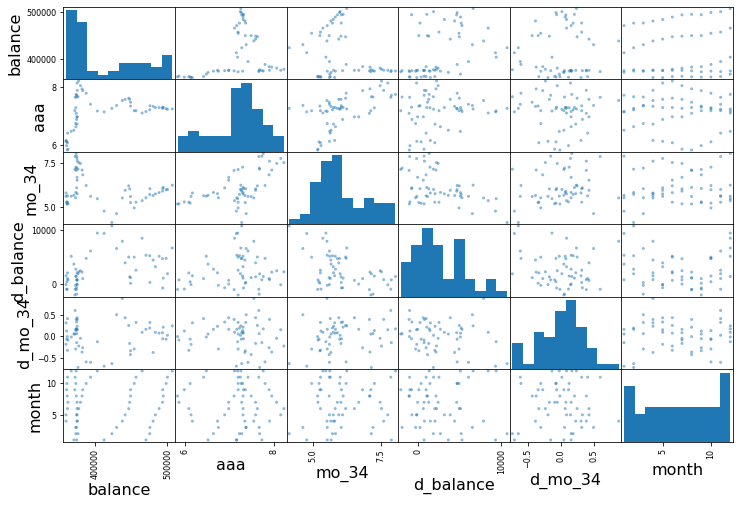

In [79]:
# Create difference variables
bankdata['d_balance'] = bankdata['balance'].diff()
bankdata['d_mo_34'] = bankdata['mo_34'].diff()
bankdata = bankdata.dropna()

# Peek at the data
display(bankdata.head())
# Plot scatter matrices
my_figure = pd.plotting.scatter_matrix(bankdata)
# Compute and display correlations
display(bankdata.corr())

# Fit a basic linear model
model = ols('d_balance ~ aaa + mo_34 + d_mo_34', bankdata)
results = model.fit()
display(results.summary())

# Checking for multicolinearity with the variance inflation factor

Recall that we can explore the presence of multicollinearity be calculating the variance inflation factor (VIF) for each of the linear model coefficients. We can import the `variance_inflation_factor` functions from `statsmodels.stats.outliers_influence` as follows:

```
from statsmodels.stats.outliers_influence import variance_inflation_factor
```

This function takes the full exogenous variable matrix as well as the index of the variable for which to calculate the VIF. Note that the VIF is not defined for the intercept, so we need to skip over the intercept in looping through our variables. 

The matrix of variables can be accessed from out model as follows:

```
variables = model.exog
```

We can then loop though the indexes that we want (in the case of the model above, we want to loop through the 1,2, and 3 indices (ignoring the 0th index, as that's for the intercept. 

In [74]:
variables = model.exog
for idx in [1, 2, 3]:
    print(variance_inflation_factor(variables, idx))

1.5637919360166637
1.6135572648795014
1.0766317193362667


From the above, it appears that there is little to no multicollinearity between the variables in question. 

# Multicollinearity with Dummy Variables

We can now create dummy variables as before, and explore whether this creates multicollinearity in our variables. Recall that by default, the `pd.get_dummies()` function creates `S` dummy variables (for `S` seasonal periods) that are mutually exclusive and therefore explicitly linearly dependent. Let's first include all dummy variables in our analysis, and see what this does to the `VIF`. 

We'll start by creating the dummy variables and fitting a multiple linear regression on all variables:

In [81]:
# Create dummy variables
bankdata['month'] = bankdata.index.month
dummy_variables = pd.get_dummies(bankdata['month'], prefix='month', drop_first=False)

# Add the dummy variables back into our original data
bankdata_months = bankdata.join(dummy_variables)
display(bankdata_months.head())

# Fit a linear regression to our data and print out the summary
model = ols('d_balance ~ aaa + mo_34 + d_mo_34 + month_1 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12', bankdata_months)
results = model.fit()
display(results.summary())

,balance,aaa,mo_34,d_balance,d_mo_34,month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,
2000-04-01,360271,6.17,5.80,1497.0,0.31,4,0,0,0,1,0,0,0,0,0,0,0,0
2000-05-01,360139,6.14,5.61,-132.0,-0.19,5,0,0,0,0,1,0,0,0,0,0,0,0
2000-06-01,362164,6.09,5.28,2025.0,-0.33,6,0,0,0,0,0,1,0,0,0,0,0,0
2000-07-01,362901,5.87,5.19,737.0,-0.09,7,0,0,0,0,0,0,1,0,0,0,0,0
2000-08-01,361878,5.84,5.18,-1023.0,-0.01,8,0,0,0,0,0,0,0,1,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     21.56
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           9.37e-15
Time:                        16:53:18   Log-Likelihood:                -477.32
No. Observations:                  57   AIC:                             984.6
Df Residuals:                      42   BIC:                             1015.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3913.9632   1894.550     -2.066      0.045   -7737.321     -90.606
aaa         3425.0234    360.986      9.488      0.000    2696.524    4153.523
mo_34      -2915.5288    239.541    -12.171      0.000   -3398.942   -2432.116
d_mo_34      420.9427    568.444      0.741      0.463    -726.225    1568.110
month_1     1666.5499    604.627      2.756      0.009     446.364    2886.736
month_2     1111.5157    620.814      1.790      0.081    -141.338    2364.369
month_3    -2879.4867    627.153     -4.591      0.000   -4145.133   -1613.841
month_4      366.6543    570.248      0.643      0.524    -784.152    1517.461
month_5    -1481.1349    558.974     -2.650      0.011   -2609.190    -353.080
month_6      364.5014    553.950      0.658      0.514    -753.416    1482.419
month_7     -526.1749    546.859     -0.962      0.341   -1629.780     577.430
month_8    -1929.7903    545.548     -3.537      0.001   -3030.751    -828.829
month_9    -3231.8288    547.172     -5.906      0.000   -4336.068   -2127.590
month_10      88.2126    551.311      0.160      0.874   -1024.378    1200.803
month_11    -939.1014    556.151     -1.689      0.099   -2061.460     183.257
month_12    3476.1198    547.589      6.348      0.000    2371.040    4581.200
==============================================================================
Omnibus:                        1.581   Durbin-Watson:                   0.931
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.496
Skew:                          -0.378   Prob(JB):                        0.473
Kurtosis:                       2.761   Cond. No.                     1.37e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.76e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Now we can check the VIF of the above to probe for multicollinearity

In [82]:
variables = model.exog
variable_names = model.exog_names
for idx in range(1, variables.shape[1]):
    name = variable_names[idx]
    vif = variance_inflation_factor(variables, idx)
    print(name, vif)

aaa 1.6337191874640387
mo_34 1.7142284929624814
d_mo_34 1.3788164349235934
month_1 inf
month_2 inf
month_3 inf
month_4 inf
month_5 inf
month_6 inf
month_7 inf
month_8 inf
month_9 inf
month_10 inf
month_11 inf
month_12 inf


/opt/miniconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Notice that because we have _explicit linear dependence_ among a subset of the variables, the `VIF` for those variables is very large (infinite). Now let's repeat the creation of dummy variables, this time leaving out the first dummy variable:

In [84]:
# Create dummy variables
bankdata['month'] = bankdata.index.month
dummy_variables = pd.get_dummies(bankdata['month'], prefix='month', drop_first=True)

# Add the dummy variables back into our original data
bankdata_months = bankdata.join(dummy_variables)
display(bankdata_months.head())

# Fit a linear regression to our data and print out the summary
model = ols('d_balance ~ aaa + mo_34 + d_mo_34 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12', bankdata_months)
results = model.fit()
display(results.summary())

,balance,aaa,mo_34,d_balance,d_mo_34,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,
2000-04-01,360271,6.17,5.80,1497.0,0.31,4,0,0,1,0,0,0,0,0,0,0,0
2000-05-01,360139,6.14,5.61,-132.0,-0.19,5,0,0,0,1,0,0,0,0,0,0,0
2000-06-01,362164,6.09,5.28,2025.0,-0.33,6,0,0,0,0,1,0,0,0,0,0,0
2000-07-01,362901,5.87,5.19,737.0,-0.09,7,0,0,0,0,0,1,0,0,0,0,0
2000-08-01,361878,5.84,5.18,-1023.0,-0.01,8,0,0,0,0,0,0,1,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     21.56
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           9.37e-15
Time:                        16:55:00   Log-Likelihood:                -477.32
No. Observations:                  57   AIC:                             984.6
Df Residuals:                      42   BIC:                             1015.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2247.4133   2118.635     -1.061      0.295   -6522.991    2028.165
aaa         3425.0234    360.986      9.488      0.000    2696.524    4153.523
mo_34      -2915.5288    239.541    -12.171      0.000   -3398.942   -2432.116
d_mo_34      420.9427    568.444      0.741      0.463    -726.225    1568.110
month_2     -555.0342    867.407     -0.640      0.526   -2305.533    1195.464
month_3    -4546.0366    887.692     -5.121      0.000   -6337.471   -2754.602
month_4    -1299.8956    855.965     -1.519      0.136   -3027.304     427.512
month_5    -3147.6849    838.689     -3.753      0.001   -4840.227   -1455.143
month_6    -1302.0486    827.534     -1.573      0.123   -2972.080     367.983
month_7    -2192.7248    824.433     -2.660      0.011   -3856.498    -528.952
month_8    -3596.3402    822.953     -4.370      0.000   -5257.126   -1935.555
month_9    -4898.3787    820.371     -5.971      0.000   -6553.954   -3242.803
month_10   -1578.3373    819.436     -1.926      0.061   -3232.025      75.351
month_11   -2605.6514    837.345     -3.112      0.003   -4295.481    -915.821
month_12    1809.5698    829.029      2.183      0.035     136.521    3482.618
==============================================================================
Omnibus:                        1.581   Durbin-Watson:                   0.931
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.496
Skew:                          -0.378   Prob(JB):                        0.473
Kurtosis:                       2.761   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
variables = model.exog
variable_names = model.exog_names
for idx in range(1, variables.shape[1]):
    name = variable_names[idx]
    vif = variance_inflation_factor(variables, idx)
    print(name, vif)

aaa 1.6337191874640384
mo_34 1.7142284929624814
d_mo_34 1.3788164349235934
month_2 1.8758406474081337
month_3 1.9646008820908263
month_4 2.240267317127644
month_5 2.1507444832082045
month_6 2.0939151226834802
month_7 2.078251510178208
month_8 2.0707949602074955
month_9 2.0578219686194807
month_10 2.0531332422434887
month_11 2.1438577948283464
month_12 2.1014884702487495


Note that we no longer have explicit linear dependence between the variables. The `VIF` for these variables is higher than for our non-dummy variables, but still much less than the standard cutoff of 5 for using the `VIF` to diagnose multicollinearity. 